In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
df = pd.read_csv('MODIS_NDVI_ERA5_16day_ArableLand_Slovakia_Lowlands.csv').drop(columns=[".geo", "system:index"])
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(["region", "date"])
df["doy"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df

,NDVI,date,dewpoint,precip,pressure,radiation,region,tmax,tmean,tmin,doy,month
0,0.292308,2000-02-18,-2.389753,373.723462,993.105883,1784.251237,Podunajska_nizina,10.136833,2.121991,-5.447357,49,2
1,0.299349,2000-03-05,-1.791054,691.162902,993.532114,2293.860659,Podunajska_nizina,13.027543,3.118598,-3.801791,65,3
2,0.330817,2000-03-21,4.919222,819.722013,983.117949,2495.099105,Podunajska_nizina,17.224799,8.230237,-0.302147,81,3
3,0.466547,2000-04-06,4.728490,185.111831,983.475586,4029.667659,Podunajska_nizina,24.313554,11.007612,-2.259595,97,4
4,0.551203,2000-04-22,9.436060,110.856610,989.908111,4802.404827,Podunajska_nizina,24.915709,16.716236,6.939031,113,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0.438047,2022-12-03,-1.750962,1037.888534,980.762228,495.435477,Vychodoslovenska_nizina,6.415161,-0.245080,-11.307929,337,12
1054,0.384781,2022-12-19,0.883081,237.023509,989.753844,533.575475,Vychodoslovenska_nizina,8.910945,2.122386,-9.156541,353,12
1055,0.472302,2023-01-01,3.051524,464.006961,985.262030,467.591728,Vychodoslovenska_nizina,9.624375,4.228935,-0.091299,1,1
1056,0.471542,2023-01-17,-1.596917,881.091088,981.830309,858.483498,Vychodoslovenska_nizina,7.218025,0.786311,-5.075965,17,1


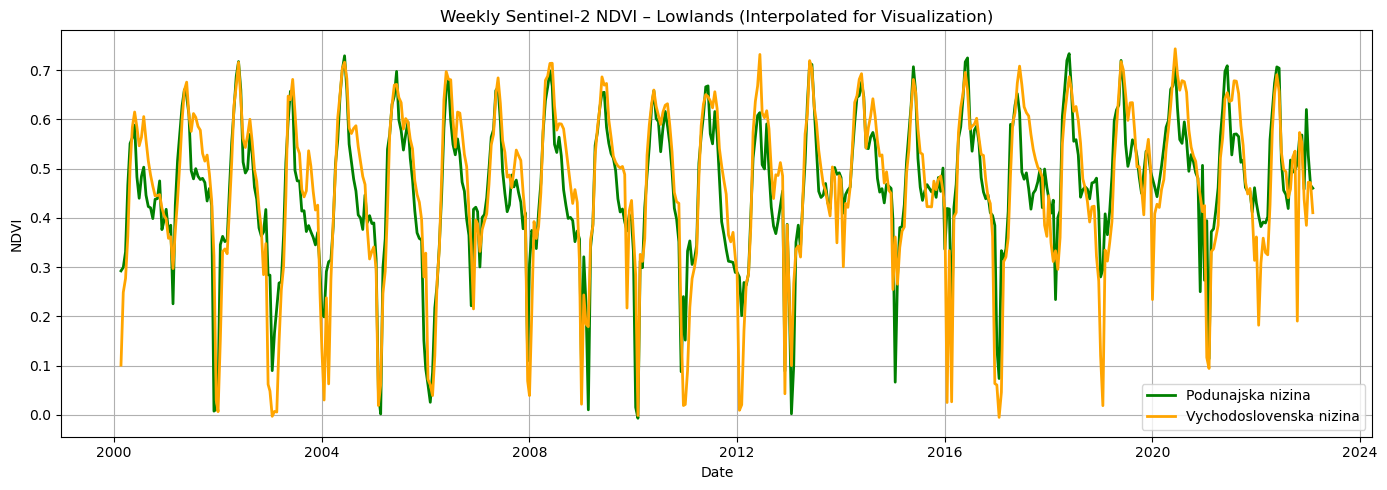

In [3]:
colors = {
    "Podunajska_nizina": "green",
    "Vychodoslovenska_nizina": "orange"
}

plt.figure(figsize=(14, 5))
for region, g in df.groupby("region"):
    plt.plot(
        g["date"],
        g["NDVI"],
        linewidth=2,
        label=region.replace("_", " "),
        color=colors.get(region, "gray")
    )

plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("Weekly Sentinel-2 NDVI – Lowlands (Interpolated for Visualization)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def add_fourier_terms(df, fourier_K, period=365.25):
    df = df.copy()
    if "doy" not in df.columns:
        df["doy"] = df["date"].dt.dayofyear

    for k in range(1, fourier_K + 1):
        df[f"sin_season_{k}"] = np.sin(2 * np.pi * k * df["doy"] / period)
        df[f"cos_season_{k}"] = np.cos(2 * np.pi * k * df["doy"] / period)

    return df


def create_lagged_features(df, columns, n_lags):
    df = df.copy()
    for col in columns:
        for lag in range(1, n_lags+1):
            df[f"{col}_lag_{lag}"] = (
                df.groupby("region")[col].shift(lag)
            )

    return df


def create_lead_feature(df, column, lead):
    df = df.copy()
    df[f"{column}_lead_{lead}"] = df.groupby("region")[column].shift(-lead)
    return df


def prepare_data(
    df,
    target_column,
    weather_columns,
    n_lags,
    lead,
    fourier_K
):
    lag_columns = [target_column] + weather_columns
    df = add_fourier_terms(df, fourier_K=fourier_K)
    df = create_lagged_features(df, lag_columns, n_lags)
    df = create_lead_feature(df, target_column, lead)

    features = weather_columns.copy()

    for col in lag_columns:
        for lag in range(1, n_lags+1):
            features.append(f"{col}_lag_{lag}")

    for k in range(1, fourier_K + 1):
        features.append(f"sin_season_{k}")
        features.append(f"cos_season_{k}")

    target = f"{target_column}_lead_{lead}"

    df = df.dropna(subset=features + [target]).reset_index(drop=True)
    print(features)
    return df, features, target


def walk_forward_split(df, train_window):
    splits = []

    for region, g in df.groupby("region"):
        g = g.sort_values("date").reset_index(drop=True)

        for i in range(train_window, len(g)):
            train = g.iloc[i - train_window : i]
            test  = g.iloc[i : i + 1]
            splits.append((region, train, test))

    return splits

In [5]:
def run_walk_forward(
    splits,
    features,
    target,
    model_class,
    model_params,
    scale_features=False
):
    rows = []

    for region, train, test in splits:
        X_train = train[features].values
        y_train = train[target].values
        X_test  = test[features].values
        y_test  = test[target].values[0]

        if scale_features:
            model = Pipeline([
                ("scaler", StandardScaler()),
                ("model", model_class(**model_params))
            ])
        else:
            model = model_class(**model_params)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        rows.append({
            "region": region,
            "date": test["date"].values[0],
            "y_true": y_test,
            "y_pred": y_pred
        })

    df = pd.DataFrame(rows)
    df["date"] = pd.to_datetime(df["date"])
    df["abs_error"] = np.abs(df["y_true"] - df["y_pred"])
    return df

In [6]:
def run_last_value_baseline(splits, horizon, target_column="NDVI"):
    rows = []
    for region, train, test in splits:
        y_pred = train[target_column].iloc[-1]
        y_true = test[f"{target_column}_lead_{horizon}"].values[0]
        rows.append({
            "region": region,
            "date": test["date"].values[0],
            "y_true": y_true,
            "y_pred": y_pred
        })
    df = pd.DataFrame(rows)
    df["date"] = pd.to_datetime(df["date"])
    df["abs_error"] = np.abs(df["y_true"] - df["y_pred"])
    return df


def run_monthly_mean_baseline(
    splits,
    horizon,
    target_column="NDVI"
):
    rows = []

    for region, train, test in splits:

        forecast_month = (test["date"] + pd.to_timedelta(horizon * 16, unit="D")
                          ).dt.month.values[0]

        vals = train[train["month"] == forecast_month][target_column]

        if len(vals) == 0:
            continue

        y_pred = vals.mean()
        y_true = test[f"{target_column}_lead_{horizon}"].values[0]

        rows.append({
            "region": region,
            "date": test["date"].values[0],
            "forecast_month": forecast_month,
            "y_true": y_true,
            "y_pred": y_pred
        })

    df = pd.DataFrame(rows)
    df["date"] = pd.to_datetime(df["date"])
    df["abs_error"] = np.abs(df["y_true"] - df["y_pred"])
    return df

In [7]:
def tag_predictions(df_pred, model, horizon, n_lags, fourier_K):
    df_pred = df_pred.copy()
    df_pred["model"] = model
    df_pred["horizon"] = horizon
    df_pred["n_lags"] = n_lags
    df_pred["fourier_K"] = fourier_K
    return df_pred


In [8]:
WINDOW_YEARS = 10
STEPS_PER_YEAR = 23
TRAIN_WINDOW = WINDOW_YEARS * STEPS_PER_YEAR

WEATHER_COLUMNS = [
    "dewpoint", "precip", "pressure",
    "radiation", "tmax", "tmean", "tmin"
]

HORIZONS = [1, 2, 3, 4, 6, 8, 10]
N_LAGS_SET = [0, 1, 2, 3]
FOURIER_K_SET = [1, 2, 4]

results = []
all_predictions = []

for h in HORIZONS:
    for n_lags in N_LAGS_SET:
        for fourier_K in FOURIER_K_SET:

            print(f"Horizon={h}, n_lags={n_lags}, fourier_K={fourier_K}")

            df_model, FEATURES, TARGET = prepare_data(
                df.copy(),
                target_column="NDVI",
                weather_columns=WEATHER_COLUMNS,
                n_lags=n_lags,
                lead=h,
                fourier_K=fourier_K
            )

            if len(df_model) < TRAIN_WINDOW:
                continue

            splits = walk_forward_split(
                df_model,
                train_window=TRAIN_WINDOW
            )

            if len(splits) == 0:
                continue


            # Ridge
            ridge_df = run_walk_forward(
                splits,
                FEATURES,
                TARGET,
                Ridge,
                model_params={"alpha": 1.0},
                scale_features=True
            )

            all_predictions.append(
                tag_predictions(ridge_df, "Ridge", h, n_lags, fourier_K)
            )

            
            # XGBoost
            xgb_df = run_walk_forward(
                splits,
                FEATURES,
                TARGET,
                XGBRegressor,
                model_params=dict(
                    n_estimators=300,
                    max_depth=4,
                    objective="reg:squarederror",
                    learning_rate=0.1,
                    n_jobs=-1,
                    tree_method="hist",
                    random_state=42
                ),
                scale_features=False
            )
            
            
            all_predictions.append(
                tag_predictions(xgb_df, "XGBoost", h, n_lags, fourier_K)
            )
            

            # Baselines
            last_df = run_last_value_baseline(
                splits,
                horizon=h,
                target_column="NDVI"
            )

            monthly_df = run_monthly_mean_baseline(
                splits,
                horizon=h,
                target_column="NDVI"
            )

            all_predictions.append(
                tag_predictions(last_df, "LastValue", h, n_lags, fourier_K)
            )

            all_predictions.append(
                tag_predictions(monthly_df, "MonthlyMean", h, n_lags, fourier_K)
            )


            # Metrics
            for name, df_res in [
                ("Ridge", ridge_df),
                ("XGBoost", xgb_df),
                ("LastValue", last_df),
                ("MonthlyMean", monthly_df)
            ]:
                for region, g in df_res.groupby("region"):
                    results.append({
                        "model": name,
                        "region": region,
                        "horizon": h,
                        "n_lags": n_lags,
                        "fourier_K": fourier_K,
                        "n_features": len(FEATURES),
                        "mae": g["abs_error"].mean(),
                        "rmse": np.sqrt(
                            mean_squared_error(g["y_true"], g["y_pred"])
                        ),
                        "n_samples": len(g)
                    })


results_df = pd.DataFrame(results)
predictions_df = (
    pd.concat(all_predictions, ignore_index=True)
      .sort_values(
          ["model", "region", "horizon", "date"]
      )
      .reset_index(drop=True)
)

results_df.to_csv(
    "results_ndvi_forecast_fourier.csv",
    index=False
)
predictions_df.to_csv(
    "predictions_ndvi_forecast_fourier.csv",
    index=False
)

Horizon=1, n_lags=0, fourier_K=1
['dewpoint', 'precip', 'pressure', 'radiation', 'tmax', 'tmean', 'tmin', 'sin_season_1', 'cos_season_1']
Horizon=1, n_lags=0, fourier_K=2
['dewpoint', 'precip', 'pressure', 'radiation', 'tmax', 'tmean', 'tmin', 'sin_season_1', 'cos_season_1', 'sin_season_2', 'cos_season_2']
Horizon=1, n_lags=0, fourier_K=4
['dewpoint', 'precip', 'pressure', 'radiation', 'tmax', 'tmean', 'tmin', 'sin_season_1', 'cos_season_1', 'sin_season_2', 'cos_season_2', 'sin_season_3', 'cos_season_3', 'sin_season_4', 'cos_season_4']
Horizon=1, n_lags=1, fourier_K=1
['dewpoint', 'precip', 'pressure', 'radiation', 'tmax', 'tmean', 'tmin', 'NDVI_lag_1', 'dewpoint_lag_1', 'precip_lag_1', 'pressure_lag_1', 'radiation_lag_1', 'tmax_lag_1', 'tmean_lag_1', 'tmin_lag_1', 'sin_season_1', 'cos_season_1']
Horizon=1, n_lags=1, fourier_K=2
['dewpoint', 'precip', 'pressure', 'radiation', 'tmax', 'tmean', 'tmin', 'NDVI_lag_1', 'dewpoint_lag_1', 'precip_lag_1', 'pressure_lag_1', 'radiation_lag_1', '

In [10]:
results_df.to_csv("ndvi_forecast_results_lowlands.csv", index=False)
predictions_df.to_csv("ndvi_forecasts_predictions_lowlands.csv", index=False)

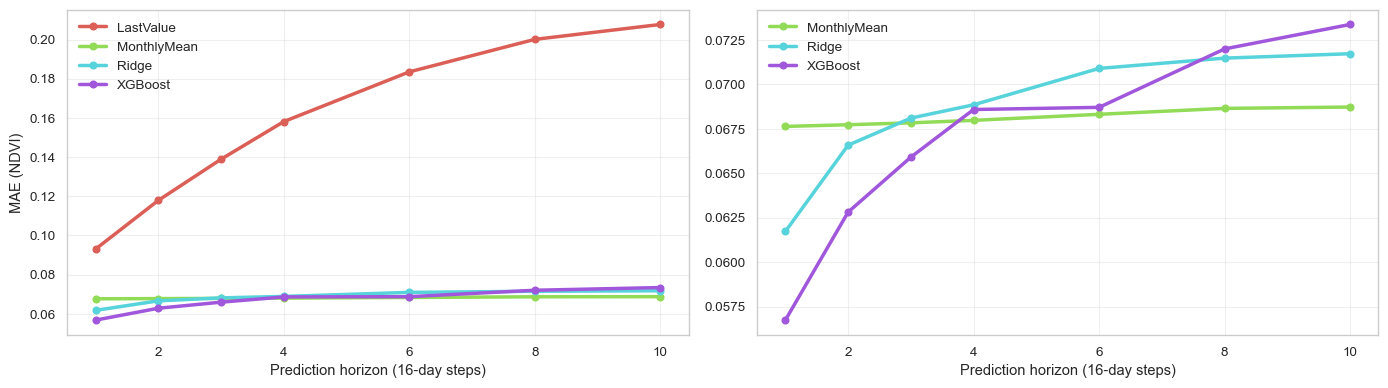

In [344]:
models_all = ["LastValue", "MonthlyMean", "Ridge", "XGBoost"]
models_no_last = ["MonthlyMean", "Ridge", "XGBoost"]

palette = dict(zip(models_all,sns.color_palette("hls", len(models_all))))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for model in models_all:
    g = results_df[results_df["model"] == model]
    g_mean = g.groupby("horizon")["mae"].mean()

    axes[0].plot(g_mean.index,g_mean.values,marker="o",lw=2.5,label=model,color=palette[model])

axes[0].set_xlabel("Prediction horizon (16-day steps)")
axes[0].set_ylabel("MAE (NDVI)")
axes[0].grid(alpha=0.3)
axes[0].legend(frameon=False)

for model in models_no_last:
    g = results_df[results_df["model"] == model]
    g_mean = g.groupby("horizon")["mae"].mean()

    axes[1].plot(g_mean.index,g_mean.values,marker="o",lw=2.5,label=model,color=palette[model])

axes[1].set_xlabel("Prediction horizon (16-day steps)")
axes[1].grid(alpha=0.3)
axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()


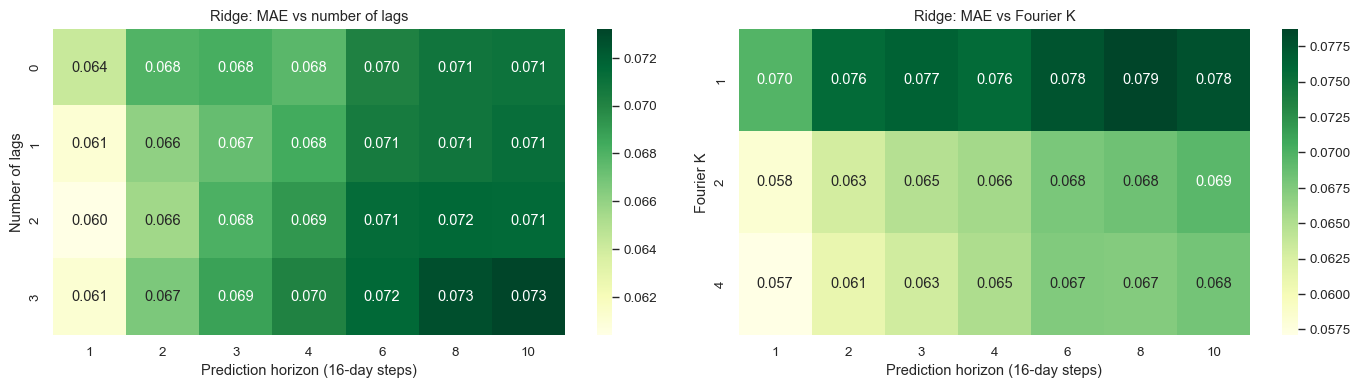

In [346]:
model_name = "Ridge"

heatmap_lags = (results_df[results_df["model"] == model_name]
    .groupby(["n_lags", "horizon"])["mae"]
    .mean()
    .reset_index()
)

pivot_lags = heatmap_lags.pivot(index="n_lags",columns="horizon",values="mae")


heatmap_fourier = (results_df[results_df["model"] == model_name]
    .groupby(["fourier_K", "horizon"])["mae"]
    .mean()
    .reset_index()
)

pivot_fourier = heatmap_fourier.pivot(index="fourier_K",columns="horizon",values="mae")


fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14, 4),sharey=False)

sns.heatmap(pivot_lags,annot=True,fmt=".3f",cmap="YlGn",ax=axes[0])
sns.heatmap(pivot_fourier,annot=True,fmt=".3f",cmap="YlGn",ax=axes[1])

axes[0].set_title(f"{model_name}: MAE vs number of lags")
axes[0].set_xlabel("Prediction horizon (16-day steps)")
axes[0].set_ylabel("Number of lags")

axes[1].set_title(f"{model_name}: MAE vs Fourier K")
axes[1].set_xlabel("Prediction horizon (16-day steps)")
axes[1].set_ylabel("Fourier K")

plt.tight_layout()
plt.show()


In [ ]:
def plot_baseline_vs_model(
    predictions_df,
    baseline_model,
    ml_model,
    horizon,
    n_lags,
    fourier_K,
    regions,
    figsize=(14, 6)
):

    fig, axes = plt.subplots(len(regions), 1,figsize=figsize,sharex=True)

    if len(regions) == 1:
        axes = [axes]

    for ax, region in zip(axes, regions):
        df = predictions_df[
            (predictions_df["horizon"] == horizon) &
            (predictions_df["n_lags"] == n_lags) &
            (predictions_df["fourier_K"] == fourier_K) &
            (predictions_df["region"] == region)
        ].sort_values("date")

        obs = df[df["model"] == baseline_model]

        ax.plot(obs["date"], obs["y_true"],
                color="black", lw=2, label="Observed NDVI")

        ax.plot(
            df[df["model"] == baseline_model]["date"],
            df[df["model"] == baseline_model]["y_pred"],
            color="gray", ls=":", lw=1.5, label=baseline_model
        )
        ax.plot(
            df[df["model"] == ml_model]["date"],
            df[df["model"] == ml_model]["y_pred"],
            color="red", ls="--", lw=1.5, label=ml_model
        )


    axes[-1].set_xlabel("Date")
    axes[0].legend(frameon=False)

    plt.suptitle(
        f"NDVI prediction: {baseline_model} vs {ml_model} "
        f"(horizon={horizon}, lags={n_lags}, K={fourier_K})",
    )

    plt.tight_layout()
    plt.show()


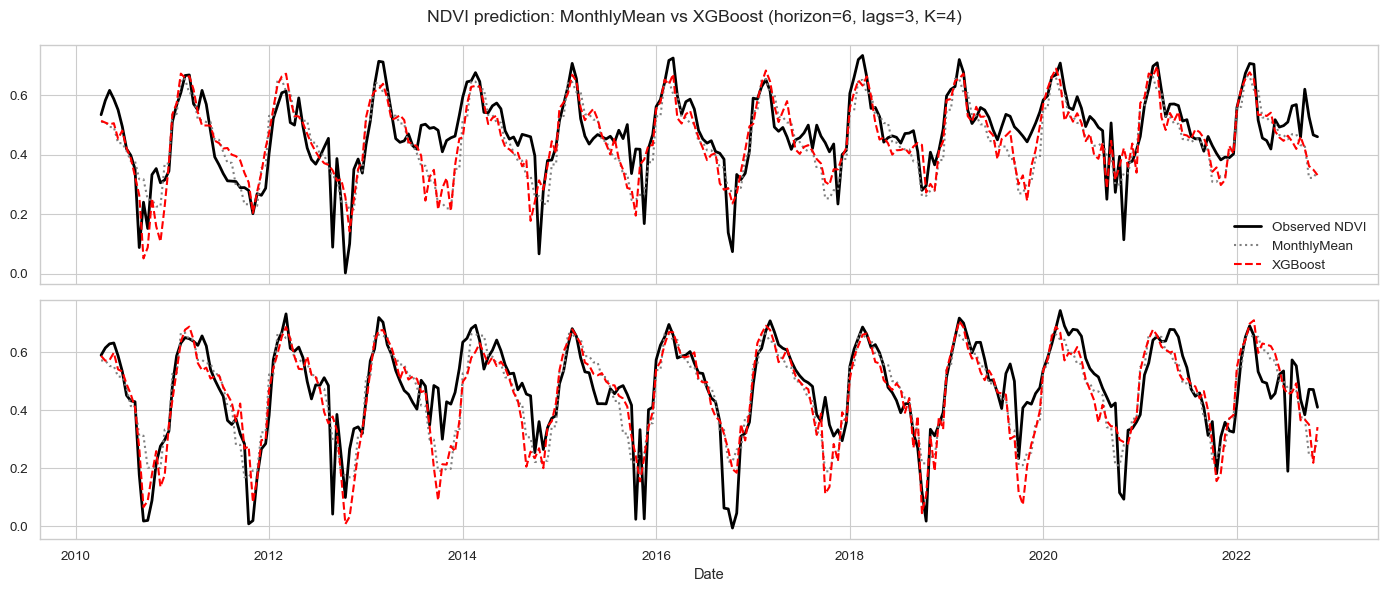

In [212]:
plot_baseline_vs_model(
    predictions_df=predictions_df,
    baseline_model="MonthlyMean",
    ml_model="XGBoost",
    horizon=6,
    n_lags=3,
    fourier_K=4,
    regions=["Podunajska_nizina", "Vychodoslovenska_nizina"]
)


In [ ]:
def plot_model_multiple_horizons(
    predictions_df,
    model,
    horizons,
    n_lags,
    fourier_K,
    regions,
    figsize=(14, 6),
    step_days=16
):
    colors = sns.color_palette("hls", len(horizons))
    fig, axes = plt.subplots(len(regions), 1, figsize=figsize, sharex=True)
    if len(regions) == 1:
        axes = [axes]

    for ax, region in zip(axes, regions):

        df_region = predictions_df[
            (predictions_df["region"] == region) &
            (predictions_df["n_lags"] == n_lags) &
            (predictions_df["fourier_K"] == fourier_K) &
            (predictions_df["model"] == model)
        ].sort_values("date")

        for h, c in zip(horizons, colors):
            df_h = df_region[df_region["horizon"] == h]

            shifted_date = df_h["date"] + pd.to_timedelta(h * step_days, unit="D")

            ax.plot(shifted_date,
                df_h["y_true"],
                color="black",
                lw=1.5,
                alpha=0 if h != horizons[0] else 1,
                label="Observed NDVI" if h == horizons[0] else None
            )

            ax.plot(
                shifted_date,
                df_h["y_pred"],
                color=c,
                ls="--",
                lw=2,
                label=f"{model} (h={h})"
            )

        ax.set_ylabel(region.replace("_", " "))
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Date")
    axes[0].legend(frameon=False)

    plt.suptitle(
        f"{model} NDVI prediction aligned to target dates "
        f"(lags={n_lags}, K={fourier_K})"
    )

    plt.tight_layout()
    plt.show()


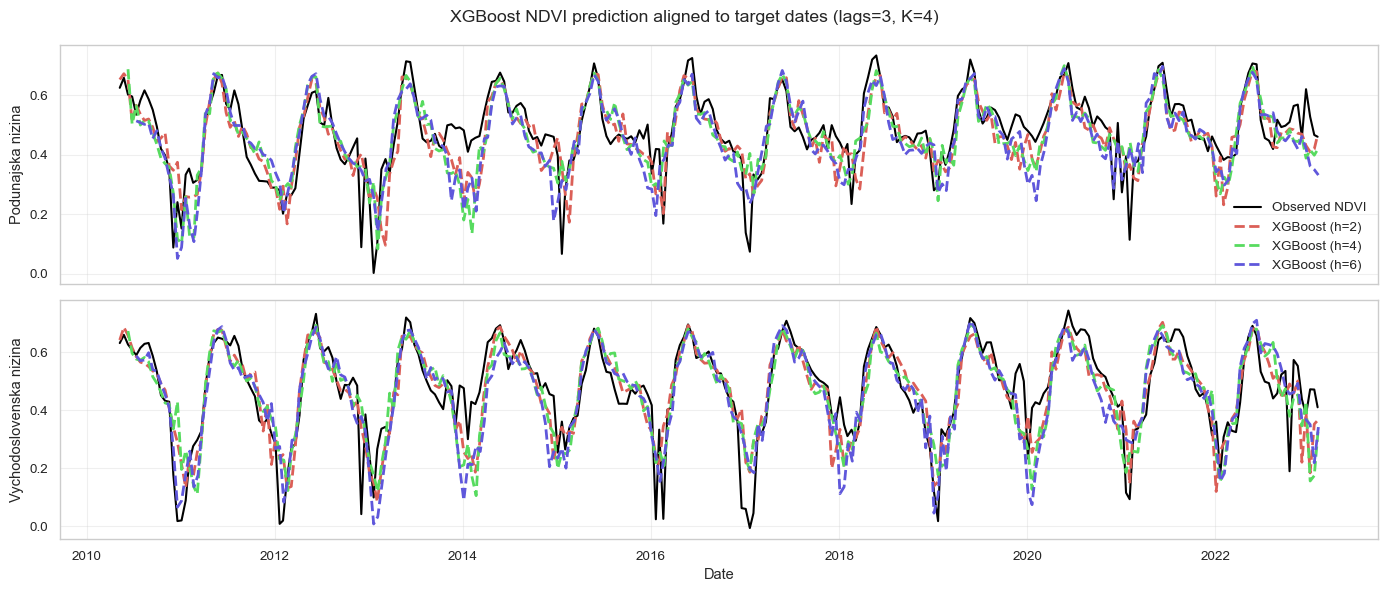

In [331]:
plot_model_multiple_horizons(
    predictions_df=predictions_df,
    model="XGBoost",
    horizons=[2, 4, 6],
    n_lags=3,
    fourier_K=4,
    regions=["Podunajska_nizina", "Vychodoslovenska_nizina"]
)


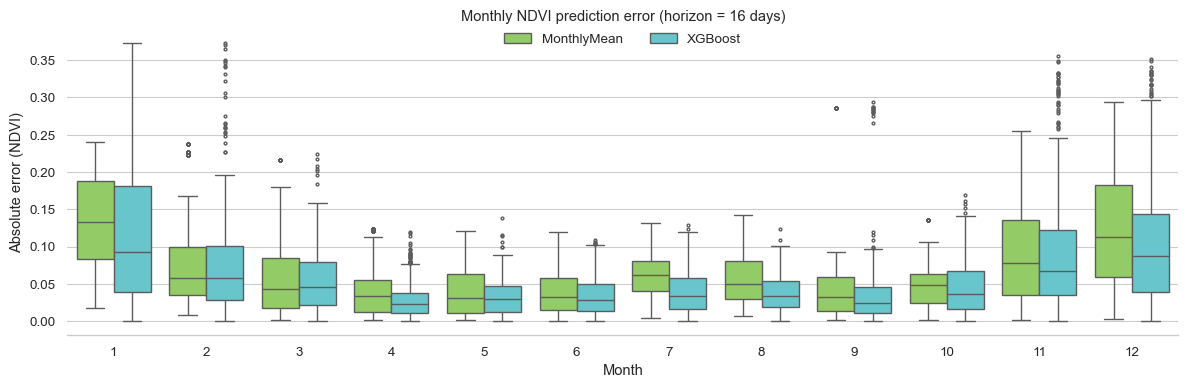

In [342]:
plot_data = predictions_df.loc[
    (predictions_df["model"].isin(["XGBoost", "MonthlyMean"])) &
    (predictions_df["horizon"] == 1)
].copy()

plot_data["date"] = pd.to_datetime(plot_data["date"])
plot_data["month"] = plot_data["date"].dt.month
hls_colors = sns.color_palette("hls", 4)
palette = {"MonthlyMean": hls_colors[1],"XGBoost": hls_colors[2],
}

plt.figure(figsize=(12, 4))

sns.boxplot(data=plot_data,x="month",y="abs_error",hue="model",order=range(1, 13),linewidth=1,fliersize=2,palette=palette)

plt.xlabel("Month")
plt.ylabel("Absolute error (NDVI)")
plt.title("Monthly NDVI prediction error (horizon = 16 days)")

plt.legend(
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.025),
    ncol=2
)

sns.despine(left=True)
plt.tight_layout()
plt.show()
